In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%load_ext google.colab.data_table
df = pd.read_csv('https://github.com/Jack12619/Shark_attacks/raw/main/attacks.csv', encoding='cp1252')

In [2]:
# om de vragen te beantwoorden zijn we de volgende kolommen nodig:
# 1. fatal + species   2. age   3. type + fatal   4. activity 
# En Case Number om dubbele invoer te verwijderen
# verwijder kollomen die we niet nodig zijn
df.drop(['Year', 'Date', 'Name', 'Sex ', 'Time', 'Country','Area', 
         'Location', 'Investigator or Source', 'pdf', 'href formula',
         'href', 'Case Number.1', 'Case Number.2', 'original order', 
         'Unnamed: 22', 'Unnamed: 23'
         ], axis=1, inplace=True)
# hernamen
df.rename(columns={'Fatal (Y/N)':'Fatal' , 'Species ': 'Species'}, inplace=True)
# verwijder lege rijen
df.dropna(axis=0, how='all', inplace=True)

In [ ]:
df.isnull().mean()   *100    # veel Null waarden

In [4]:
# wegens weinig meer info gezocht en de meest recente file gevonden op ; https://www.sharkattackfile.net/incidentlog.htm
# dit blijkt de nieuwste versie te zijn van het Shark attack log.

In [5]:
df2 = pd.read_csv("https://github.com/Jack12619/Shark_attacks/raw/main/GSAF5.csv", sep=";", low_memory=False)

In [6]:
df2.drop(['Year', 'Date', 'Name', 'Sex ', 'Time', 'Country','Area', 
         'Location', 'Investigator or Source', 'pdf', 'href formula',
         'href', 'Case Number.1', 'Case Number.2', 'original order', 
         'Unnamed: 22', 'Unnamed: 23'
         ], axis=1, inplace=True)
# verwijder lege rijen en kolommen
df2.dropna(axis=0, how='all', inplace=True)
df2.dropna(axis=1, how='all', inplace=True)
# Hernamen
df2.rename(columns={'Fatal (Y/N)':'Fatal' , 'Species ': 'Species'}, inplace=True)

In [7]:
# foute en dubbele waarden filteren 
df2.loc[df2['Case Number'] == '0',  'Case Number'] = np.nan
df2.loc[df2['Case Number'] == 'xx',  'Case Number'] = np.nan
df2['Case Number'] = df2['Case Number'].drop_duplicates()

In [8]:
# Boat en Invalid rijen eruit halen
df2 = df2[df2.Type != ('Invalid')]
df2 = df2[df2.Type != ('Boat')]           # Ik haal o.a. de aanvallen op een boot eruit, dit creert een bias.
df2 = df2[df2.Type != ('Unconfirmed')]    # Het gaat mijns inzien om aanvallen op mensen
df2 = df2[df2.Type != ('Unverified')]

df2['Type'].replace('?', np.nan, inplace=True)
df2['Type'].replace('Questionable', 'Unprovoked', inplace=True)   # Dit creert ook een bias,
df2['Type'].replace('Sea Disaster', 'Unprovoked', inplace=True)   # deze en volgende acties ook
df2['Type'].replace('Watercraft', 'Unprovoked', inplace=True)     
df2['Type'].replace('Under investigation', 'Unprovoked', inplace=True)
df2['Type'] = df2['Type'].fillna('Unknown')

In [9]:
# activities filteren en opschonen
df2['Activity'] = df2['Activity'].astype(str)
for actie in df2['Activity']:
  activities = ['Swimming', 'Fishing', 'Diving', 'Surfing','Wading','Boarding', 'Bathing', 'Other','Unknown']  # Ik neem alleen neem de meest voorkomende activiteiten
  if actie in activities:
    continue
  elif 'fishing' in actie.lower():
     df2['Activity'].replace({f'{actie}':'Fishing'}, inplace=True)
  elif 'diving' in actie.lower():
     df2['Activity'].replace({f'{actie}':'Diving'}, inplace=True)
  elif 'swimming' in actie.lower():
     df2['Activity'].replace({f'{actie}':'Swimming'}, inplace=True)
  elif 'surfing' in actie.lower():
     df2['Activity'].replace({f'{actie}':'Surfing'}, inplace=True)
  elif 'wading' in actie.lower():
     df2['Activity'].replace({f'{actie}':'Wading'}, inplace=True)
  elif 'bathing' in actie.lower():
     df2['Activity'].replace({f'{actie}':'Bathing'}, inplace=True)
  elif 'boarding' in actie.lower():
     df2['Activity'].replace({f'{actie}':'Boarding'}, inplace=True)
  else:
     df2['Activity'].replace({f'{actie}':'Other'}, inplace=True)   # Indien onbekend of overig zet ik ze onder "Other"

In [10]:
# Age opschonen
for age in df2['Age']:
  children = ['teen', 'teens', '18 months', 'young', 'a minor','6½', '2½', '!6', 'Both 11']
  adults = ['elderly', 'mid-30s','40s', 'adult', '(adult)','>50',  '/"middle-age/"', ' 30', ' 43' ]
  bad = ['MAKE LINE GREEN', 'X', 'A.M.','\xa0 ', '!!', 'F', 'M', '', ' ', '  ', '   ' ]
  if type(age) == int:
    continue
  if type(age) == str:
    if age.lower() in children:
      df2['Age'].replace({f'{age}': int(random.randrange(1,18))}, inplace=True)   # Vervang de fouting ingegeven leeftijd voor een random leeftijd.
    elif age.lower() in adults:                                                   # De leeftijd valt nog wel in de juiste groep; kind/volwassen.
      df2['Age'].replace({f'{age}': int(random.randrange(19,80))}, inplace=True)
    elif age in bad:
      df2['Age'].replace(f'{age}', np.nan, inplace=True)
    elif len(age) > 2:
      sel_age = age[:age.find('')]
      df2['Age'].replace(f'{age}', sel_age, inplace=True)

df2['Age'] = df2['Age'].fillna(np.nan)
df2['Age'] = pd.to_numeric(df2['Age'], errors='coerce')

In [11]:
# Fatal opschonen 
df2['Fatal'] = df2['Fatal'].astype(str)
for fatal in df2['Fatal']:
  if 'y' in fatal.lower():
     df2['Fatal'].replace({f'{fatal}':'Yes'}, inplace=True)    # we bevestigen alleen de aanvallen waarvan het zeker is dat ze dodelijk waren.
  elif 'N' in fatal:                                           # Dat creeert een bias want er kunnen uiteraard meer dodelijk aanvallen zijn geweest
     df2['Fatal'].replace({f'{fatal}':'No'}, inplace=True)
  elif 'unknown' in fatal.lower():
     df2['Fatal'].replace({f'{fatal}':'Unknown'}, inplace=True)
  elif 'm' in fatal.lower():
     df2['Fatal'].replace({f'{fatal}':'Unknown'}, inplace=True)
  elif 'f' in fatal.lower():
     df2['Fatal'].replace({f'{fatal}':'Unknown'}, inplace=True) 
  else:
     df2['Fatal'].replace({f'{fatal}':'Unknown'}, inplace=True)

df2['Fatal'] = df2.Fatal.fillna('Unknown')

In [12]:
# We nemen de 15 meest voorkomende soorten, de kleine aantallen zetten we onder 'unknown'. Dit creeert een kleine Bias maar zal geen sterke invloed hebben op de totale aantallen
df2['Species'] = df2['Species'].astype(str)
count = 0
while count < 8000:
  for shark in df2['Species']:
    known_species = ['Bull shark', 'Whaler shark', 'Nurse shark', 'Blacktip shark',
                    'Mako shark', 'Tiger shark', 'White shark', 'Brown shark',
                    'Cocktail shark', 'Dog shark','Lemon shark', 'Blue shark',
                    'Sand shark', 'Hammerhead shark', 'Wobbegong shark','Unknown'
                    ]
    correct_names = {'bull' : 'Bull shark',
                    'whaler' : 'Whaler shark',
                    'nurse' : 'Nurse shark',
                    'black-tipped' : 'Blacktip shark',
                    'blacktip' : 'Blacktip shark',
                    'mako' : 'Mako shark',
                    'tiger': 'Tiger shark',
                    'white' : 'White shark',
                    'brown': 'Brown shark',
                    'cocktail' : 'Cocktail shark',
                    'dog' : 'Dog shark',
                    'lemon': 'Lemon shark',
                    'blue' : 'Blue shark',
                    'sand' : 'Sand shark',
                    'hammer' : 'Hammerhead shark',
                    'wobbegong': 'Wobbegong shark' 
                    }
    if shark in known_species:
      count += 1
      continue
    elif ',' in shark:
        shark_name = shark[:shark.find(',')]      # hier wordt de naam aangepast maar dat betekend nog niet meteen dat ie correct is. Vandaar de While loop
        df2['Species'].replace({f'{shark}': shark_name}, inplace=True)  
    for name in correct_names:
     if name in shark.lower():
       df2['Species'].replace(f'{shark}', correct_names.get(f'{shark}'), inplace=True)
     elif ('involvement' or 'unconfirmed') in shark.lower():
       df2['Species'].replace({f'{shark}': 'Shark involvement unconfirmed'}, inplace=True)
     elif ('invalid') in shark.lower():
       df2['Species'].replace({f'{shark}': 'Shark involvement unconfirmed'}, inplace=True)
     else:
       df2['Species'].replace({f'{shark}': 'Unknown'}, inplace=True)

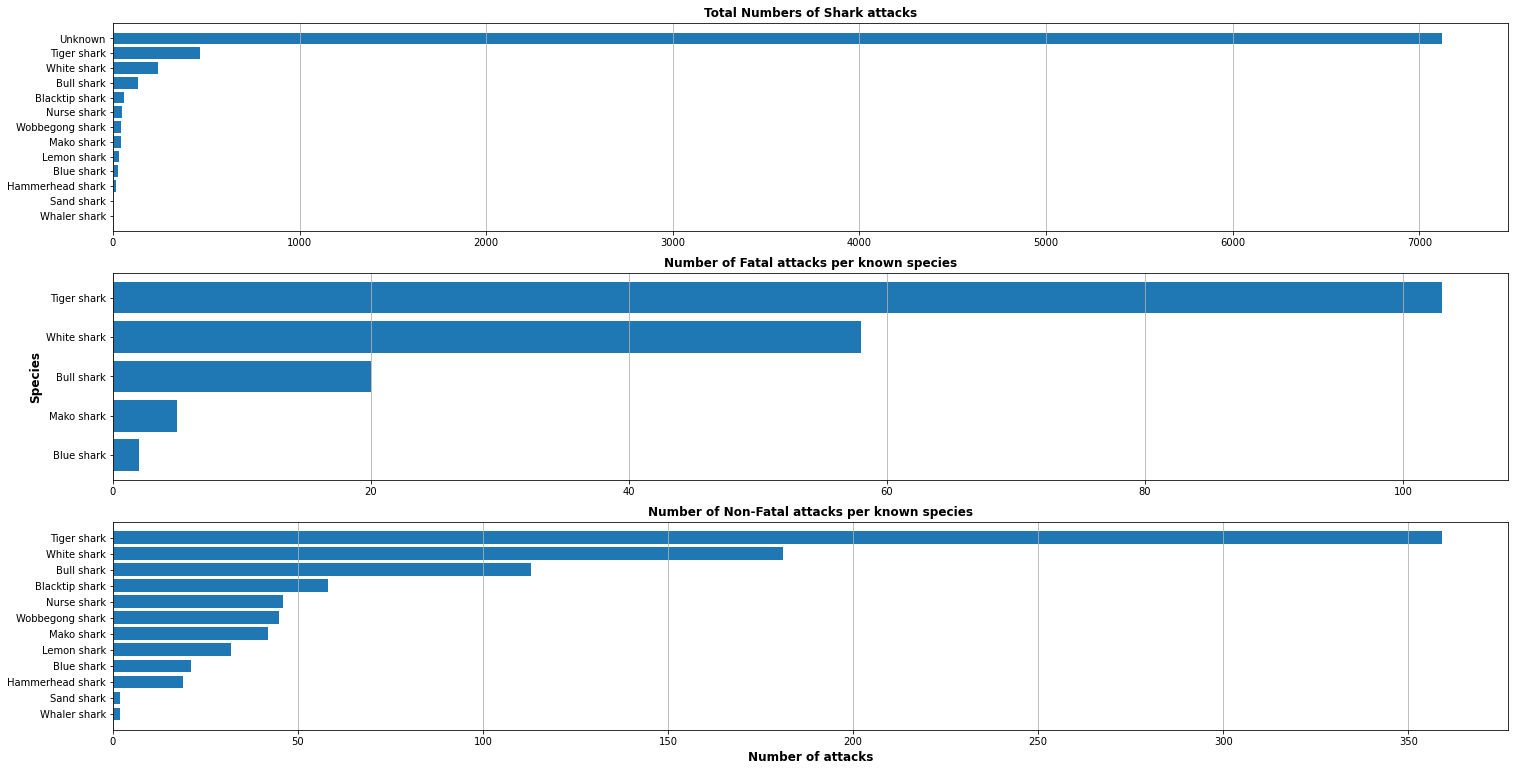

In [13]:
df5 = df2[df2.Species != ('Shark involvement unconfirmed')]   # we filteren er een aantal aanvallen die waarvan het onzeker is of er een haai bij betrokken is. 
certain_attacks = df5.loc[~df5.Species.str.contains("Unknown")]
fatal_species = certain_attacks.loc[df5.Fatal == "Yes", ['Species']]
fatal_attacks = fatal_species.Species.value_counts()
non_fatal_species = certain_attacks.loc[df5.Fatal == "No", ['Species']]
non_fatal_attacks = non_fatal_species['Species'].value_counts()

x = df5['Species'].unique()
y = df5['Species'].value_counts()
x1 = fatal_species['Species'].unique()
y1 = fatal_species['Species'].value_counts()
x2 = non_fatal_species['Species'].unique()
y2 = non_fatal_species['Species'].value_counts()

fig,((ax,ax1,ax2)) = plt.subplots(nrows=3, figsize=(25,13))

ax.barh(x, y)
ax.invert_yaxis()
ax.set_title("Total Numbers of Shark attacks", fontsize=12, fontweight='bold')
ax.grid(axis='x')

ax1.barh(x1, y1)
ax1.invert_yaxis()
ax1.set_ylabel('Species', fontsize=12, fontweight='bold')
ax1.set_title("Number of Fatal attacks per known species", fontsize=12, fontweight='bold')
ax1.grid(axis='x')

ax2.barh(x2, y2)
ax2.invert_yaxis()
ax2.set_xlabel('Number of attacks', fontsize=12, fontweight='bold')
ax2.set_title("Number of Non-Fatal attacks per known species", fontsize=12, fontweight='bold')
ax2.grid(axis='x')

plt.show()

1. **what are the most dangerous types of sharks to humans?**
*- Tiger & White Shark maar zoals te zien is op de chart is er bij een groot aantal aanvallen niet bekend welke soort het was dus de informatie is incompleet.*


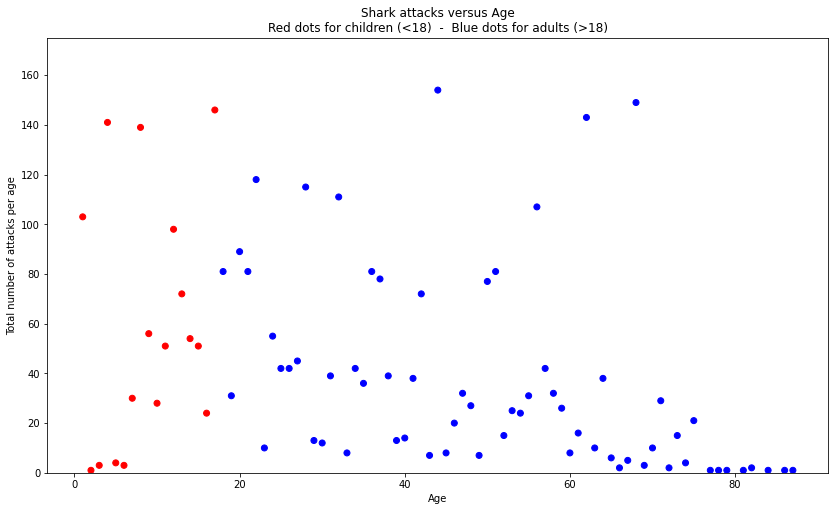

In [14]:
x = df2['Age'].unique()
y = df2['Age'].value_counts(dropna=False)
cc = ["red" if age < 18 else "blue" for age in x]
fig,ax = plt.subplots(figsize= (14, 8))

ax.scatter(x, y, color= cc)
ax.set_ylim(0,175)
ax.set_title("Shark attacks versus Age\nRed dots for children (<18)  -  Blue dots for adults (>18)")
ax.set_xlabel('Age')
ax.set_ylabel('Total number of attacks per age')
plt.show()

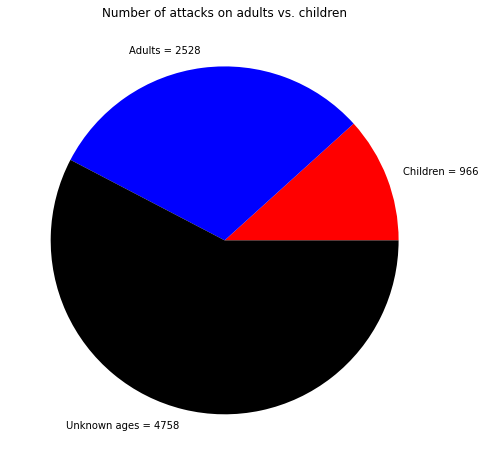

In [15]:
# Omdat de scatterplot nog niet direct een relatie laat zien tussen leeftijd en het aantal aanvallen maak ik een Pie chart
children = ((df2['Age'])<18).sum()
adults = ((df2['Age'])>=18).sum()
unknown = (df2['Age'].isnull().sum())
total= (f'Children = {children}',
        f'Adults = {adults}',
        f'Unknown ages = {unknown}')
labels = total
data = [children, adults, unknown]
mycolors = ['r', 'b', 'black']

fig,ax = plt.subplots(figsize=(8, 8))

ax.pie(data, labels = labels, colors = mycolors)
ax.set_title('Number of attacks on adults vs. children')
plt.show()

2. **are children more likely to be attacked by sharks?**

Het lijkt er wel op, hoewel er in de Scatter plot niet direct een link te zien is, zijn er 966 bevestigde aanvallen op kinderen versus 2528 op volwassenen. Echter is in veruit de meeste gevallen de leeftijd niet bekend dus dit is niet volledig bevestigd.

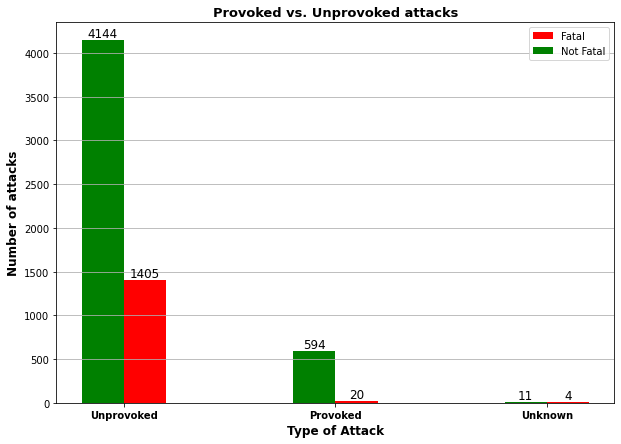

In [17]:
df3 = df2[['Type','Fatal']]
fatal_attacks = df3.loc[df3['Fatal'] == 'Yes',['Type','Fatal']].value_counts()
non_fatal_attacks = df3.loc[df3['Fatal'] == 'No',['Type','Fatal']].value_counts()
labels = df3['Fatal'].value_counts()
x = np.arange(len(labels))
bar_width = 0.2
fig,ax = plt.subplots(figsize =(10, 7))

p1 = ax.bar(x+bar_width/2, fatal_attacks, bar_width, color='r', label= 'Fatal')
p2 = ax.bar(x-bar_width/2, non_fatal_attacks, bar_width, color='g', label= 'Not Fatal')

ax.set_ylabel('Number of attacks', fontsize=12, fontweight='semibold')
ax.set_title('Provoked vs. Unprovoked attacks', fontsize=13, fontweight='semibold')
ax.set_xlabel('Type of Attack', fontsize=12, fontweight='semibold')
ax.set_xticklabels(labels=['Unprovoked', 'Provoked', 'Unknown'], fontweight='semibold')
ax.set_xticks(x)
ax.legend()
ax.grid(axis='y')
for bar in ax.patches:
  bar_value = bar.get_height()
  text_x = bar.get_x() + bar.get_width() / 2
  text_y = bar.get_y() + bar_value
  ax.text(text_x, text_y, bar_value, ha='center', va='bottom',
          size=12)

plt.show()

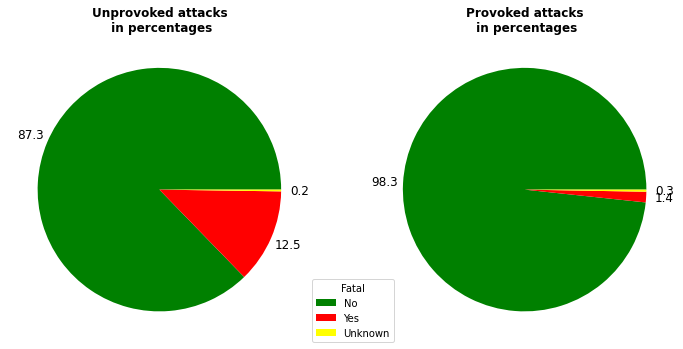

In [18]:
labels = df3['Fatal'].unique()
mycolors = ['green', 'red', 'yellow']

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(12, 12))

ax1.pie(non_fatal_attacks, autopct= '%.1f', textprops= dict(fontsize= 'large', weight= 'medium'), pctdistance= 1.15, colors= mycolors )
ax1.set_title('Unprovoked attacks\n in percentages', weight='semibold')
ax1.legend(title='Fatal', labels =labels, loc= (1,0))

ax2.pie(fatal_attacks,autopct='%.1f', pctdistance=1.15, textprops= dict(fontsize= 'large'), colors= mycolors)
ax2.set_title('Provoked attacks\n in percentages', weight='semibold')

plt.show()

3. are shark attacks where sharks were provoked more or less dangerous?

Hoewel er bij het opschonen van de data een redelijke bias is ontstaan door een aantal waarden zoals 'Boat, Sea Distaster em Watercraft' te vervangen voor Unprovoked en de definitie van 'Provoked' niet echt helder is, lijkt het er wel op dat de Unprovoked attacks vaker voorkomen en dodelijk zijn.


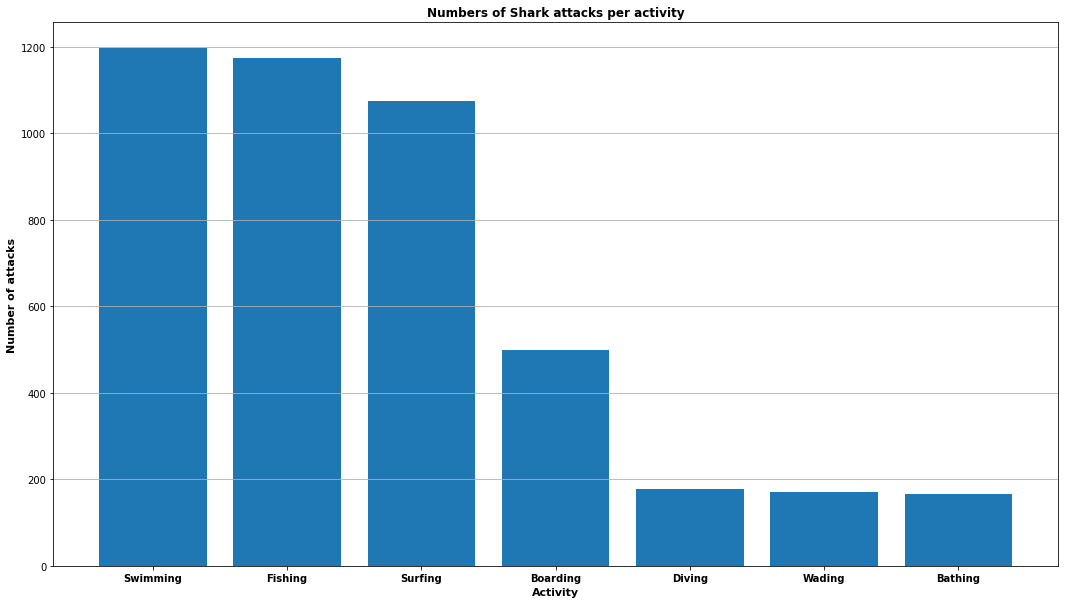

In [19]:
df4 = df2[df2['Activity'] != 'Other']  # We filteren "other" eruit omdat dit ons niks verteld
x = df4['Activity'].unique()
y = df4['Activity'].value_counts()

fig,ax = plt.subplots(figsize=(18,10))

ax.bar(x, y)
ax.set_title("Numbers of Shark attacks per activity", fontsize=12, fontweight='semibold')
ax.set_ylabel('Number of attacks', fontsize=11, fontweight='semibold')
ax.set_xlabel('Activity', fontsize=11, fontweight='semibold')
ax.set_xticklabels(labels=x, fontweight='semibold')
ax.grid(axis='y')
plt.show()

4. are certain activities more likely to result in a shark attack?

Zwemmen, vissen en surfen zijn het meest gevaarlijk.